## Trial of as many Time Series Analysis as possible for solar resource from SAM (System Advisor Model)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [92]:
import pymc3 as pm
import statsmodels.api as sm
import theano
import theano.tensor as tt
from pandas.plotting import register_matplotlib_converters

plt.style.use("seaborn")
register_matplotlib_converters()

In [4]:
from agrivoltaics_supply_side_management.solar_irradiation.clearsky import get_clearsky

In [5]:
vancouver_data = pd.read_csv("../../data/weather_data/vancouver_bc_canada_49.263566_-123.138572_psm3_60_tmy.csv",
                             header=[2])

In [6]:
vancouver_data

,Year,Month,Day,Hour,Minute,DNI,DHI,GHI,Dew Point,Temperature,Pressure,Wind Direction,Wind Speed
0,2011,1,1,0,30,0,0,0,-8,-2,1020,75,2.1
1,2011,1,1,1,30,0,0,0,-8,-3,1020,74,2.1
2,2011,1,1,2,30,0,0,0,-8,-3,1020,74,2.0
3,2011,1,1,3,30,0,0,0,-8,-3,1020,70,1.9
4,2011,1,1,4,30,0,0,0,-9,-3,1020,64,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2011,12,31,19,30,0,0,0,-8,-2,1020,66,2.2
8756,2011,12,31,20,30,0,0,0,-8,-2,1020,69,2.2
8757,2011,12,31,21,30,0,0,0,-8,-2,1020,72,2.2
8758,2011,12,31,22,30,0,0,0,-8,-2,1020,76,2.2


In [7]:
vancouver_meta_data = pd.read_csv("../../data/weather_data/vancouver_bc_canada_49.263566_-123.138572_psm3_60_tmy.csv",
                                  header=[0], skiprows=lambda x: x not in [0, 1])

In [8]:
vancouver_meta_data

,Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,Dew Point Units,DHI Units,DNI Units,GHI Units,Temperature Units,Pressure Units,Wind Direction Units,Wind Speed,Surface Albedo Units,Version
0,NSRDB,262015,-,-,-,49.25,-123.14,-8,39,-8,c,w/m2,w/m2,w/m2,c,mbar,Degrees,m/s,NaN,3.1.1


In [9]:
vancouver_data['Datetime'] = pd.to_datetime(vancouver_data[['Year', 'Month', 'Day', 'Hour', 'Minute']])

In [10]:
vancouver_data

,Year,Month,Day,Hour,Minute,DNI,DHI,GHI,Dew Point,Temperature,Pressure,Wind Direction,Wind Speed,Datetime
0,2011,1,1,0,30,0,0,0,-8,-2,1020,75,2.1,2011-01-01 00:30:00
1,2011,1,1,1,30,0,0,0,-8,-3,1020,74,2.1,2011-01-01 01:30:00
2,2011,1,1,2,30,0,0,0,-8,-3,1020,74,2.0,2011-01-01 02:30:00
3,2011,1,1,3,30,0,0,0,-8,-3,1020,70,1.9,2011-01-01 03:30:00
4,2011,1,1,4,30,0,0,0,-9,-3,1020,64,1.8,2011-01-01 04:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2011,12,31,19,30,0,0,0,-8,-2,1020,66,2.2,2011-12-31 19:30:00
8756,2011,12,31,20,30,0,0,0,-8,-2,1020,69,2.2,2011-12-31 20:30:00
8757,2011,12,31,21,30,0,0,0,-8,-2,1020,72,2.2,2011-12-31 21:30:00
8758,2011,12,31,22,30,0,0,0,-8,-2,1020,76,2.2,2011-12-31 22:30:00


In [11]:
vancouver_data.set_index('Datetime', inplace=True)

In [12]:
vancouver_data

,Year,Month,Day,Hour,Minute,DNI,DHI,GHI,Dew Point,Temperature,Pressure,Wind Direction,Wind Speed
Datetime,,,,,,,,,,,,,
2011-01-01 00:30:00,2011,1,1,0,30,0,0,0,-8,-2,1020,75,2.1
2011-01-01 01:30:00,2011,1,1,1,30,0,0,0,-8,-3,1020,74,2.1
2011-01-01 02:30:00,2011,1,1,2,30,0,0,0,-8,-3,1020,74,2.0
2011-01-01 03:30:00,2011,1,1,3,30,0,0,0,-8,-3,1020,70,1.9
2011-01-01 04:30:00,2011,1,1,4,30,0,0,0,-9,-3,1020,64,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31 19:30:00,2011,12,31,19,30,0,0,0,-8,-2,1020,66,2.2
2011-12-31 20:30:00,2011,12,31,20,30,0,0,0,-8,-2,1020,69,2.2
2011-12-31 21:30:00,2011,12,31,21,30,0,0,0,-8,-2,1020,72,2.2


In [13]:
vancouver_data.index = vancouver_data.index.tz_localize('Canada/Pacific', 
                                                        ambiguous='NaT', nonexistent='shift_forward')

In [14]:
vancouver_data

,Year,Month,Day,Hour,Minute,DNI,DHI,GHI,Dew Point,Temperature,Pressure,Wind Direction,Wind Speed
Datetime,,,,,,,,,,,,,
2011-01-01 00:30:00-08:00,2011,1,1,0,30,0,0,0,-8,-2,1020,75,2.1
2011-01-01 01:30:00-08:00,2011,1,1,1,30,0,0,0,-8,-3,1020,74,2.1
2011-01-01 02:30:00-08:00,2011,1,1,2,30,0,0,0,-8,-3,1020,74,2.0
2011-01-01 03:30:00-08:00,2011,1,1,3,30,0,0,0,-8,-3,1020,70,1.9
2011-01-01 04:30:00-08:00,2011,1,1,4,30,0,0,0,-9,-3,1020,64,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31 19:30:00-08:00,2011,12,31,19,30,0,0,0,-8,-2,1020,66,2.2
2011-12-31 20:30:00-08:00,2011,12,31,20,30,0,0,0,-8,-2,1020,69,2.2
2011-12-31 21:30:00-08:00,2011,12,31,21,30,0,0,0,-8,-2,1020,72,2.2


In [15]:
vancouver_data.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)

In [16]:
vancouver_data

,DNI,DHI,GHI,Dew Point,Temperature,Pressure,Wind Direction,Wind Speed
Datetime,,,,,,,,
2011-01-01 00:30:00-08:00,0,0,0,-8,-2,1020,75,2.1
2011-01-01 01:30:00-08:00,0,0,0,-8,-3,1020,74,2.1
2011-01-01 02:30:00-08:00,0,0,0,-8,-3,1020,74,2.0
2011-01-01 03:30:00-08:00,0,0,0,-8,-3,1020,70,1.9
2011-01-01 04:30:00-08:00,0,0,0,-9,-3,1020,64,1.8
...,...,...,...,...,...,...,...,...
2011-12-31 19:30:00-08:00,0,0,0,-8,-2,1020,66,2.2
2011-12-31 20:30:00-08:00,0,0,0,-8,-2,1020,69,2.2
2011-12-31 21:30:00-08:00,0,0,0,-8,-2,1020,72,2.2


In [17]:
vancouver_data_ghi = vancouver_data.GHI

In [18]:
vancouver_data_ghi

Datetime
2011-01-01 00:30:00-08:00    0
2011-01-01 01:30:00-08:00    0
2011-01-01 02:30:00-08:00    0
2011-01-01 03:30:00-08:00    0
2011-01-01 04:30:00-08:00    0
                            ..
2011-12-31 19:30:00-08:00    0
2011-12-31 20:30:00-08:00    0
2011-12-31 21:30:00-08:00    0
2011-12-31 22:30:00-08:00    0
2011-12-31 23:30:00-08:00    0
Name: GHI, Length: 8760, dtype: int64

In [19]:
vancouver_data_ghi.shape

(8760,)

In [20]:
vancouver_data_ghi_0706 = vancouver_data_ghi[vancouver_data_ghi.index.strftime('%m-%d')=='07-06']

In [21]:
vancouver_data_ghi_0706

Datetime
2002-07-06 00:30:00-07:00      0
2002-07-06 01:30:00-07:00      0
2002-07-06 02:30:00-07:00      0
2002-07-06 03:30:00-07:00      0
2002-07-06 04:30:00-07:00     11
2002-07-06 05:30:00-07:00    102
2002-07-06 06:30:00-07:00    264
2002-07-06 07:30:00-07:00    446
2002-07-06 08:30:00-07:00    603
2002-07-06 09:30:00-07:00    739
2002-07-06 10:30:00-07:00    841
2002-07-06 11:30:00-07:00    901
2002-07-06 12:30:00-07:00    915
2002-07-06 13:30:00-07:00    878
2002-07-06 14:30:00-07:00    796
2002-07-06 15:30:00-07:00    677
2002-07-06 16:30:00-07:00    529
2002-07-06 17:30:00-07:00    365
2002-07-06 18:30:00-07:00    186
2002-07-06 19:30:00-07:00     43
2002-07-06 20:30:00-07:00      0
2002-07-06 21:30:00-07:00      0
2002-07-06 22:30:00-07:00      0
2002-07-06 23:30:00-07:00      0
Name: GHI, dtype: int64

<AxesSubplot:xlabel='Datetime'>

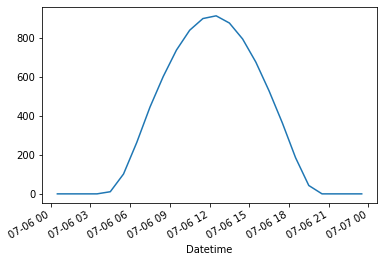

In [22]:
vancouver_data_ghi_0706.plot()

In [23]:
vancouver_data_ghi_0717 = vancouver_data_ghi[vancouver_data_ghi.index.strftime('%m-%d')=='07-17']

In [24]:
vancouver_data_ghi_0717

Datetime
2002-07-17 00:30:00-07:00      0
2002-07-17 01:30:00-07:00      0
2002-07-17 02:30:00-07:00      0
2002-07-17 03:30:00-07:00      0
2002-07-17 04:30:00-07:00      0
2002-07-17 05:30:00-07:00     16
2002-07-17 06:30:00-07:00      8
2002-07-17 07:30:00-07:00    165
2002-07-17 08:30:00-07:00    238
2002-07-17 09:30:00-07:00    172
2002-07-17 10:30:00-07:00    278
2002-07-17 11:30:00-07:00    382
2002-07-17 12:30:00-07:00    350
2002-07-17 13:30:00-07:00    316
2002-07-17 14:30:00-07:00    211
2002-07-17 15:30:00-07:00    286
2002-07-17 16:30:00-07:00    192
2002-07-17 17:30:00-07:00     96
2002-07-17 18:30:00-07:00     24
2002-07-17 19:30:00-07:00      5
2002-07-17 20:30:00-07:00      0
2002-07-17 21:30:00-07:00      0
2002-07-17 22:30:00-07:00      0
2002-07-17 23:30:00-07:00      0
Name: GHI, dtype: int64

<AxesSubplot:xlabel='Datetime'>

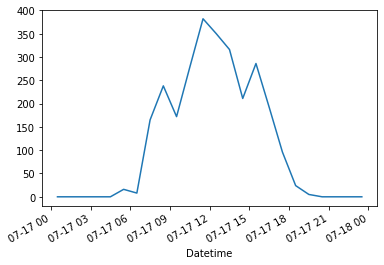

In [25]:
vancouver_data_ghi_0717.plot()

### Get clearsky data for the same day

In [26]:
vancouver_data_ghi_0717.index

DatetimeIndex(['2002-07-17 00:30:00-07:00', '2002-07-17 01:30:00-07:00',
               '2002-07-17 02:30:00-07:00', '2002-07-17 03:30:00-07:00',
               '2002-07-17 04:30:00-07:00', '2002-07-17 05:30:00-07:00',
               '2002-07-17 06:30:00-07:00', '2002-07-17 07:30:00-07:00',
               '2002-07-17 08:30:00-07:00', '2002-07-17 09:30:00-07:00',
               '2002-07-17 10:30:00-07:00', '2002-07-17 11:30:00-07:00',
               '2002-07-17 12:30:00-07:00', '2002-07-17 13:30:00-07:00',
               '2002-07-17 14:30:00-07:00', '2002-07-17 15:30:00-07:00',
               '2002-07-17 16:30:00-07:00', '2002-07-17 17:30:00-07:00',
               '2002-07-17 18:30:00-07:00', '2002-07-17 19:30:00-07:00',
               '2002-07-17 20:30:00-07:00', '2002-07-17 21:30:00-07:00',
               '2002-07-17 22:30:00-07:00', '2002-07-17 23:30:00-07:00'],
              dtype='datetime64[ns, Canada/Pacific]', name='Datetime', freq=None)

In [27]:
vancouver_clearsky_ghi_0717 = get_clearsky(49.263566, -123.138572, 
                                           'Canada/Pacific', vancouver_data_ghi_0717.index,
                                           location_name='Vancouver, BC, Canada')['ghi']

In [28]:
vancouver_clearsky_ghi_0717

Datetime
2002-07-17 00:30:00-07:00      0.000000
2002-07-17 01:30:00-07:00      0.000000
2002-07-17 02:30:00-07:00      0.000000
2002-07-17 03:30:00-07:00      0.000000
2002-07-17 04:30:00-07:00      0.000000
2002-07-17 05:30:00-07:00      0.049742
2002-07-17 06:30:00-07:00     68.561097
2002-07-17 07:30:00-07:00    222.671380
2002-07-17 08:30:00-07:00    391.407154
2002-07-17 09:30:00-07:00    550.889221
2002-07-17 10:30:00-07:00    686.901315
2002-07-17 11:30:00-07:00    788.912796
2002-07-17 12:30:00-07:00    849.411568
2002-07-17 13:30:00-07:00    864.027151
2002-07-17 14:30:00-07:00    831.702461
2002-07-17 15:30:00-07:00    754.742638
2002-07-17 16:30:00-07:00    638.714004
2002-07-17 17:30:00-07:00    492.259700
2002-07-17 18:30:00-07:00    327.127361
2002-07-17 19:30:00-07:00    159.822949
2002-07-17 20:30:00-07:00     25.086362
2002-07-17 21:30:00-07:00      0.000000
2002-07-17 22:30:00-07:00      0.000000
2002-07-17 23:30:00-07:00      0.000000
Name: ghi, dtype: float64

<AxesSubplot:xlabel='Datetime'>

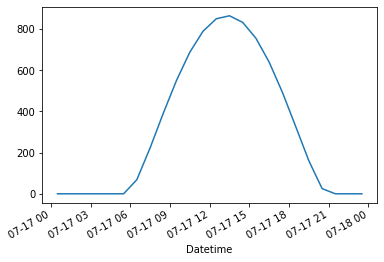

In [29]:
vancouver_clearsky_ghi_0717.plot()

<AxesSubplot:xlabel='Datetime'>

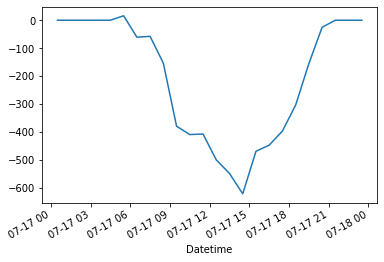

In [30]:
(vancouver_data_ghi_0717 - vancouver_clearsky_ghi_0717).plot()

In [31]:
vancouver_clearsky_ghi_0717.max()

864.0271509397637

In [32]:
vancouver_data_ghi_0717.max()

382

#### Change the clear sky data to the scale of cloudy sky data

In [33]:
vancouver_clearsky_ghi_scaled_0717 = vancouver_clearsky_ghi_0717 * (
    vancouver_data_ghi_0717.max() / vancouver_clearsky_ghi_0717.max())

<AxesSubplot:xlabel='Datetime'>

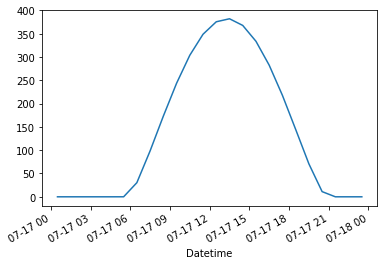

In [34]:
vancouver_clearsky_ghi_scaled_0717.plot()

In [35]:
vancouver_data_data_residual_0717 = vancouver_data_ghi_0717 - vancouver_clearsky_ghi_scaled_0717

<AxesSubplot:xlabel='Datetime'>

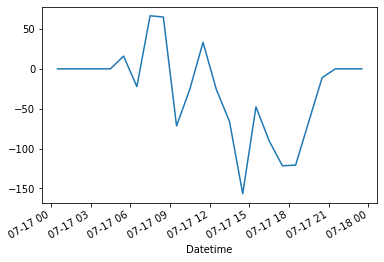

In [36]:
vancouver_data_data_residual_0717.plot()

### Try to apply Bayesian Time Series Analysis on this data, using PyMC3

#### Since the data above is used in time_series_pymc3_sarimax notebook already, use another data with minute interval.

In [37]:
import pymc3 as pm

In [38]:
varrennes_data = pd.read_csv("../../data/weather_data/solar_irradiance_20140717_var01.csv",
                             header=[0])

In [39]:
varrennes_data

,Date (yyyy-mm-dd),Timestamp (hh:mm:ss.nnn),G1 (W/m2),G2 (W/m2)
0,2014-07-17,03:46:00.000,0,0
1,2014-07-17,03:47:00.000,0,0
2,2014-07-17,03:48:00.000,0,0
3,2014-07-17,03:49:00.000,0,0
4,2014-07-17,03:50:00.000,0,0
...,...,...,...,...
72669,2014-07-17,20:10:00.000,0,0
72670,2014-07-17,20:11:00.000,0,0
72671,2014-07-17,20:12:00.000,0,0
72672,2014-07-17,20:13:00.000,0,0


In [40]:
type(varrennes_data['Date (yyyy-mm-dd)'].loc[0])

str

In [41]:
varrennes_data['Datetime'] = pd.to_datetime(varrennes_data['Date (yyyy-mm-dd)'] 
                                            + ' ' + varrennes_data['Timestamp (hh:mm:ss.nnn)'])

In [42]:
varrennes_data

,Date (yyyy-mm-dd),Timestamp (hh:mm:ss.nnn),G1 (W/m2),G2 (W/m2),Datetime
0,2014-07-17,03:46:00.000,0,0,2014-07-17 03:46:00
1,2014-07-17,03:47:00.000,0,0,2014-07-17 03:47:00
2,2014-07-17,03:48:00.000,0,0,2014-07-17 03:48:00
3,2014-07-17,03:49:00.000,0,0,2014-07-17 03:49:00
4,2014-07-17,03:50:00.000,0,0,2014-07-17 03:50:00
...,...,...,...,...,...
72669,2014-07-17,20:10:00.000,0,0,2014-07-17 20:10:00
72670,2014-07-17,20:11:00.000,0,0,2014-07-17 20:11:00
72671,2014-07-17,20:12:00.000,0,0,2014-07-17 20:12:00
72672,2014-07-17,20:13:00.000,0,0,2014-07-17 20:13:00


In [43]:
varrennes_data.set_index('Datetime', inplace=True)

In [44]:
varrennes_data

,Date (yyyy-mm-dd),Timestamp (hh:mm:ss.nnn),G1 (W/m2),G2 (W/m2)
Datetime,,,,
2014-07-17 03:46:00,2014-07-17,03:46:00.000,0,0
2014-07-17 03:47:00,2014-07-17,03:47:00.000,0,0
2014-07-17 03:48:00,2014-07-17,03:48:00.000,0,0
2014-07-17 03:49:00,2014-07-17,03:49:00.000,0,0
2014-07-17 03:50:00,2014-07-17,03:50:00.000,0,0
...,...,...,...,...
2014-07-17 20:10:00,2014-07-17,20:10:00.000,0,0
2014-07-17 20:11:00,2014-07-17,20:11:00.000,0,0
2014-07-17 20:12:00,2014-07-17,20:12:00.000,0,0


In [45]:
varrennes_data.drop(columns=['Date (yyyy-mm-dd)', 'Timestamp (hh:mm:ss.nnn)'], inplace=True)

In [46]:
varrennes_data

,G1 (W/m2),G2 (W/m2)
Datetime,,
2014-07-17 03:46:00,0,0
2014-07-17 03:47:00,0,0
2014-07-17 03:48:00,0,0
2014-07-17 03:49:00,0,0
2014-07-17 03:50:00,0,0
...,...,...
2014-07-17 20:10:00,0,0
2014-07-17 20:11:00,0,0
2014-07-17 20:12:00,0,0


In [47]:
varrennes_data_by_minite = varrennes_data[(varrennes_data.index.second == 0) & (varrennes_data.index.microsecond == 0)]

In [48]:
varrennes_data_by_minite

,G1 (W/m2),G2 (W/m2)
Datetime,,
2014-07-17 03:46:00,0,0
2014-07-17 03:47:00,0,0
2014-07-17 03:48:00,0,0
2014-07-17 03:49:00,0,0
2014-07-17 03:50:00,0,0
...,...,...
2014-07-17 20:10:00,0,0
2014-07-17 20:11:00,0,0
2014-07-17 20:12:00,0,0


In [49]:
pd.options.display.max_columns

20

In [50]:
varrennes_data_by_minite[901:1000]

,G1 (W/m2),G2 (W/m2)
Datetime,,
2014-07-17 18:47:00,90,45
2014-07-17 18:48:00,83,44
2014-07-17 18:49:00,80,43
2014-07-17 18:50:00,82,43
2014-07-17 18:51:00,78,41
...,...,...
2014-07-17 20:10:00,0,0
2014-07-17 20:11:00,0,0
2014-07-17 20:12:00,0,0


In [51]:
import pytz
pytz.all_timezones

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [52]:
varrennes_data_by_minite.index = varrennes_data_by_minite.index.tz_localize('Canada/Eastern', 
                                                        ambiguous='NaT', nonexistent='shift_forward')

In [53]:
varrennes_data_by_minite

,G1 (W/m2),G2 (W/m2)
Datetime,,
2014-07-17 03:46:00-04:00,0,0
2014-07-17 03:47:00-04:00,0,0
2014-07-17 03:48:00-04:00,0,0
2014-07-17 03:49:00-04:00,0,0
2014-07-17 03:50:00-04:00,0,0
...,...,...
2014-07-17 20:10:00-04:00,0,0
2014-07-17 20:11:00-04:00,0,0
2014-07-17 20:12:00-04:00,0,0


<AxesSubplot:xlabel='Datetime'>

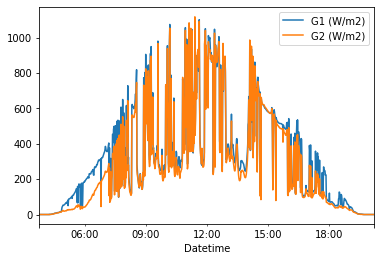

In [54]:
varrennes_data_by_minite.plot()

In [55]:
varrennes_data_ghi_0717 = varrennes_data_by_minite['G1 (W/m2)']

<AxesSubplot:xlabel='Datetime'>

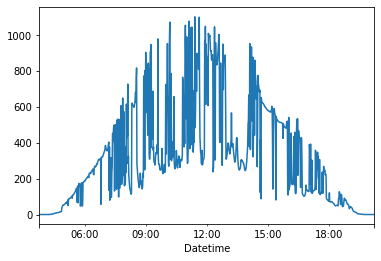

In [56]:
varrennes_data_ghi_0717.plot()

In [57]:
varrennes_clearsky_ghi_0717 = get_clearsky(45.616084, -73.386362, 
                                           'Canada/Eastern', varrennes_data_by_minite.index,
                                           location_name='Varrennes, QC, Canada')['ghi']

<AxesSubplot:xlabel='Datetime'>

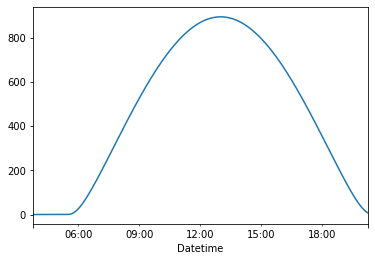

In [58]:
varrennes_clearsky_ghi_0717.plot()

In [59]:
varrennes_clearsky_ghi_scaled_0717 = varrennes_clearsky_ghi_0717 * (
    varrennes_data_ghi_0717.max() / varrennes_clearsky_ghi_0717.max())

<AxesSubplot:xlabel='Datetime'>

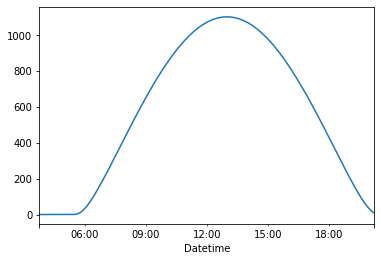

In [60]:
varrennes_clearsky_ghi_scaled_0717.plot()

In [61]:
varrennes_data_data_residual_0717 = varrennes_data_ghi_0717 - varrennes_clearsky_ghi_scaled_0717

<AxesSubplot:xlabel='Datetime'>

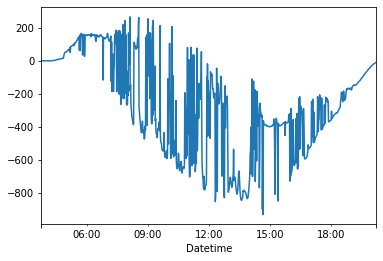

In [62]:
varrennes_data_data_residual_0717.plot()

#### This seems to be because clearsky data seems to be shifted toward the later time. It's better to make it get shifted toward the earlier time to match the observed data. 

In [63]:
varrenens_data_solar_noon_time = varrennes_data_ghi_0717[varrennes_data_ghi_0717 == varrennes_data_ghi_0717.max()].index

In [64]:
varrenens_data_solar_noon_time

DatetimeIndex(['2014-07-17 11:25:00-04:00'], dtype='datetime64[ns, Canada/Eastern]', name='Datetime', freq=None)

In [65]:
varrennes_clearsky_ghi_scaled_solar_noon_time = varrennes_clearsky_ghi_scaled_0717[
    varrennes_clearsky_ghi_scaled_0717 == varrennes_clearsky_ghi_scaled_0717.max()].index

In [66]:
varrennes_clearsky_ghi_scaled_solar_noon_time

DatetimeIndex(['2014-07-17 13:00:00-04:00'], dtype='datetime64[ns, Canada/Eastern]', name='Datetime', freq=None)

In [67]:
varrenens_data_solar_noon_time_indexer_array = varrennes_clearsky_ghi_scaled_0717.index.get_indexer_for(
    varrenens_data_solar_noon_time)

In [68]:
varrenens_data_solar_noon_time_indexer = varrenens_data_solar_noon_time_indexer_array[0]

In [69]:
varrenens_data_solar_noon_time_indexer

459

In [70]:
varrennes_clearsky_ghi_scaled_solar_noon_time_indexer_array = varrennes_clearsky_ghi_scaled_0717.index.get_indexer_for(
    varrennes_clearsky_ghi_scaled_solar_noon_time)

In [71]:
varrennes_clearsky_ghi_scaled_solar_noon_time_indexer = varrennes_clearsky_ghi_scaled_solar_noon_time_indexer_array[0]

In [72]:
varrennes_clearsky_ghi_scaled_solar_noon_time_indexer

554

In [73]:
shift_period = varrenens_data_solar_noon_time_indexer - varrennes_clearsky_ghi_scaled_solar_noon_time_indexer

In [74]:
shift_period

-95

In [75]:
varrennes_clearsky_ghi_scaled_shifted_0717 = varrennes_clearsky_ghi_scaled_0717.shift(
    periods=shift_period, fill_value=0)

In [76]:
varrennes_clearsky_ghi_scaled_shifted_0717

Datetime
2014-07-17 03:46:00-04:00    0.000000
2014-07-17 03:47:00-04:00    0.000000
2014-07-17 03:48:00-04:00    0.006139
2014-07-17 03:49:00-04:00    0.028549
2014-07-17 03:50:00-04:00    0.062448
                               ...   
2014-07-17 20:10:00-04:00    0.000000
2014-07-17 20:11:00-04:00    0.000000
2014-07-17 20:12:00-04:00    0.000000
2014-07-17 20:13:00-04:00    0.000000
2014-07-17 20:14:00-04:00    0.000000
Name: ghi, Length: 989, dtype: float64

<AxesSubplot:xlabel='Datetime'>

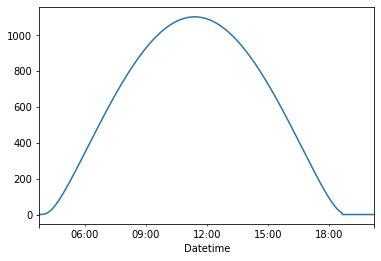

In [77]:
varrennes_clearsky_ghi_scaled_shifted_0717.plot()

In [78]:
varrennes_data_data_residual_0717_2 = varrennes_data_ghi_0717 - varrennes_clearsky_ghi_scaled_shifted_0717

<AxesSubplot:xlabel='Datetime'>

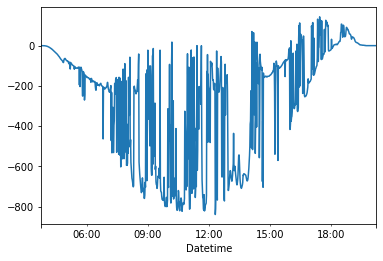

In [79]:
varrennes_data_data_residual_0717_2.plot()

#### I cannot necessarily see the improvement. I try differencing. 

In [80]:
varrennes_data_data_residual_diff_0717_2 = varrennes_data_data_residual_0717_2.diff()

In [81]:
varrennes_data_data_residual_diff_0717_2

Datetime
2014-07-17 03:46:00-04:00         NaN
2014-07-17 03:47:00-04:00    0.000000
2014-07-17 03:48:00-04:00   -0.006139
2014-07-17 03:49:00-04:00   -0.022410
2014-07-17 03:50:00-04:00   -0.033899
                               ...   
2014-07-17 20:10:00-04:00    0.000000
2014-07-17 20:11:00-04:00    0.000000
2014-07-17 20:12:00-04:00    0.000000
2014-07-17 20:13:00-04:00    0.000000
2014-07-17 20:14:00-04:00    0.000000
Length: 989, dtype: float64

<AxesSubplot:xlabel='Datetime'>

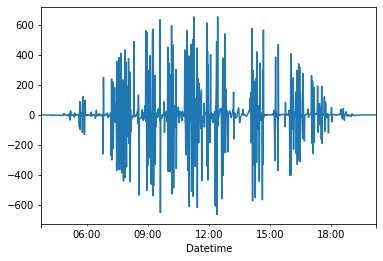

In [82]:
varrennes_data_data_residual_diff_0717_2.plot()

#### Also, the difference of the data before that.

In [83]:
varrennes_data_data_residual_diff_0717 = varrennes_data_data_residual_0717.diff()

In [84]:
varrennes_data_data_residual_diff_0717

Datetime
2014-07-17 03:46:00-04:00         NaN
2014-07-17 03:47:00-04:00    0.000000
2014-07-17 03:48:00-04:00    0.000000
2014-07-17 03:49:00-04:00    0.000000
2014-07-17 03:50:00-04:00    0.000000
                               ...   
2014-07-17 20:10:00-04:00    1.400452
2014-07-17 20:11:00-04:00    1.329822
2014-07-17 20:12:00-04:00    1.258323
2014-07-17 20:13:00-04:00    1.186133
2014-07-17 20:14:00-04:00    1.113456
Length: 989, dtype: float64

<AxesSubplot:xlabel='Datetime'>

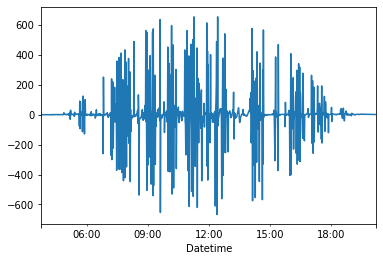

In [85]:
varrennes_data_data_residual_diff_0717.plot()

#### Compare these two.

In [86]:
varrennes_data_data_residual_diff_0717.compare(varrennes_data_data_residual_diff_0717_2)

,self,other
Datetime,,
2014-07-17 03:48:00-04:00,0.000000,-0.006139
2014-07-17 03:49:00-04:00,0.000000,-0.022410
2014-07-17 03:50:00-04:00,0.000000,-0.033899
2014-07-17 03:51:00-04:00,0.000000,-0.048685
2014-07-17 03:52:00-04:00,0.000000,-0.067182
...,...,...
2014-07-17 20:10:00-04:00,1.400452,0.000000
2014-07-17 20:11:00-04:00,1.329822,0.000000
2014-07-17 20:12:00-04:00,1.258323,0.000000


#### The only difference seems to be shift. 

#### Look at the difference of the original data (without subtracting clearsky data)

In [87]:
varrennes_data_ghi_diff_0717 = varrennes_data_ghi_0717.diff()

In [88]:
varrennes_data_ghi_diff_0717

Datetime
2014-07-17 03:46:00-04:00    NaN
2014-07-17 03:47:00-04:00    0.0
2014-07-17 03:48:00-04:00    0.0
2014-07-17 03:49:00-04:00    0.0
2014-07-17 03:50:00-04:00    0.0
                            ... 
2014-07-17 20:10:00-04:00    0.0
2014-07-17 20:11:00-04:00    0.0
2014-07-17 20:12:00-04:00    0.0
2014-07-17 20:13:00-04:00    0.0
2014-07-17 20:14:00-04:00    0.0
Name: G1 (W/m2), Length: 989, dtype: float64

<AxesSubplot:xlabel='Datetime'>

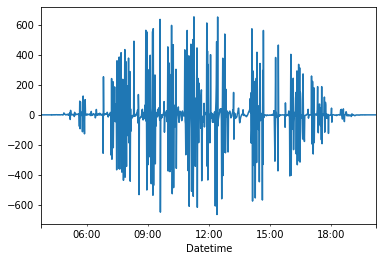

In [89]:
varrennes_data_ghi_diff_0717.plot()

In [90]:
varrennes_data_ghi_diff_0717.compare(varrennes_data_data_residual_diff_0717)

,self,other
Datetime,,
2014-07-17 05:23:00-04:00,-11.0,-11.006139
2014-07-17 05:24:00-04:00,17.0,16.977590
2014-07-17 05:25:00-04:00,1.0,0.966101
2014-07-17 05:26:00-04:00,0.0,-0.048685
2014-07-17 05:27:00-04:00,1.0,0.932818
...,...,...
2014-07-17 20:10:00-04:00,0.0,1.400452
2014-07-17 20:11:00-04:00,0.0,1.329822
2014-07-17 20:12:00-04:00,0.0,1.258323


In [91]:
varrennes_data_ghi_diff_0717.compare(varrennes_data_data_residual_diff_0717_2)

,self,other
Datetime,,
2014-07-17 03:48:00-04:00,0.0,-0.006139
2014-07-17 03:49:00-04:00,0.0,-0.022410
2014-07-17 03:50:00-04:00,0.0,-0.033899
2014-07-17 03:51:00-04:00,0.0,-0.048685
2014-07-17 03:52:00-04:00,0.0,-0.067182
...,...,...
2014-07-17 18:36:00-04:00,17.0,18.329822
2014-07-17 18:37:00-04:00,40.0,41.258323
2014-07-17 18:38:00-04:00,-5.0,-3.813867


#### I just try to apply time series analysis to each data and see how it goes.

#### Start with difference data for original data

In [93]:
ghi_diff_sarimax_model = sm.tsa.statespace.SARIMAX(varrennes_data_ghi_diff_0717, order=(1, 0, 1))

/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [94]:
ghi_diff_sarimax_result = ghi_diff_sarimax_model.fit(disp=False)

In [95]:
ghi_diff_sarimax_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              G1 (W/m2)   No. Observations:                  989
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -6279.144
Date:                Fri, 14 Oct 2022   AIC                          12564.288
Time:                        17:35:38   BIC                          12578.978
Sample:                    07-17-2014   HQIC                         12569.874
                         - 07-17-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3531      0.028     12.593      0.000       0.298       0.408
ma.L1         -0.8303      0.019    -44.238      0.000      -0.867      -0.793
sigma2      1.938e+04    501.707     38.638      0.000    1.84e+04    2.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               931.81
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### P is less than 0.05. So this time, it seems to be a good model. 

#### Use PyMC3

In [96]:
# Set sampling params
ndraws = 3000  # number of draws from the distribution
nburn = 600  # number of "burn-in points" (which will be discarded)

In [97]:
from agrivoltaics_supply_side_management.util.statsmodels_to_pymc3_tensor import Loglike

In [98]:
ghi_diff_sarimax_loglike = Loglike(ghi_diff_sarimax_model)

In [99]:
with pm.Model() as m:
    # Priors
    ar_l1_sarimax = pm.Uniform("ar.l1", -0.99, 0.99)
    ma_l1_sarimax = pm.Uniform("ma.l1", -0.99, 0.99)
    sigma2_sarimax = pm.InverseGamma("sigma2", 2, 4)
    
    # convert variables to tensor vectors
    theta_sarimax = tt.as_tensor_variable([ar_l1_sarimax, ma_l1_sarimax, sigma2_sarimax])
    
    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", ghi_diff_sarimax_loglike, observed=theta_sarimax)
    
    # Draw samples
    trace_sarimax = pm.sample(
        ndraws,
        tune=nburn,
        return_inferencedata=True,
        cores=1,
        compute_convergence_checks=False,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma2, ma.l1, ar.l1]


/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tools/numdiff.py:246: RuntimeWarning: invalid value encountered in multiply
  increments = np.identity(n) * 1j * epsilon


Sampling 2 chains for 600 tune and 3_000 draw iterations (1_200 + 6_000 draws total) took 602 seconds.
The acceptance probability does not match the target. It is 0.9101023048642566, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8925243839703029, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning: A valid var_name should be provided, found {'ma.L1', 'ar.L1'} expected from {'ma.l1', 'sigma2', 'ar.l1'}
  warnings.warn(


<Figure size 576x396 with 0 Axes>

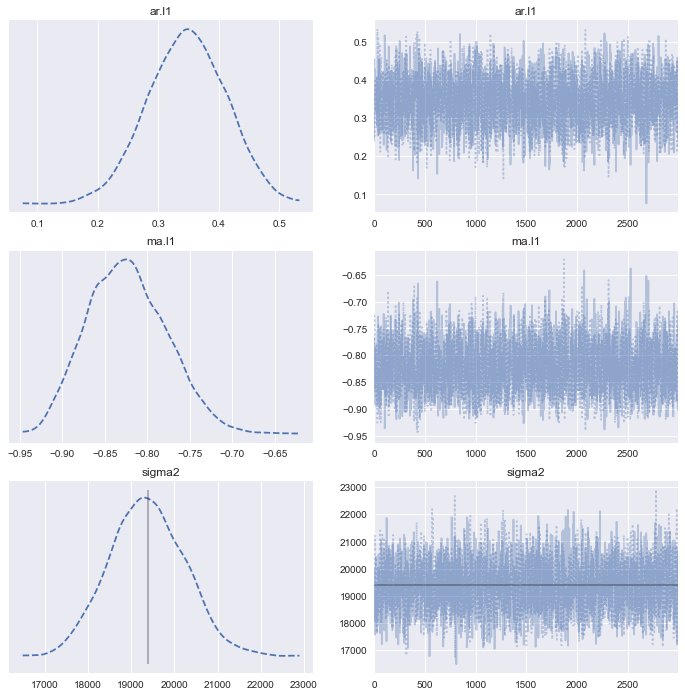

In [100]:
plt.tight_layout()

_ = pm.plot_trace(
    trace_sarimax,
    lines=[(k, {}, [v]) for k, v in dict(ghi_diff_sarimax_result.params).items()],
    combined=True,
    figsize=(12, 12),
)

In [101]:
pm.summary(trace_sarimax)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar.l1,0.347,0.064,0.229,0.468,0.001,0.001,2109.0,2129.0,1.0
ma.l1,-0.824,0.046,-0.906,-0.736,0.001,0.001,2133.0,1984.0,1.0
sigma2,19366.729,869.364,17655.131,20878.818,14.973,10.604,3382.0,3074.0,1.0


In [102]:
ghi_diff_sarimax_params = pm.summary(trace_sarimax)["mean"].values

In [103]:
ghi_diff_sarimax_params

array([ 3.4700000e-01, -8.2400000e-01,  1.9366729e+04])

In [105]:
result_bayes_ghi_diff_sarimax = ghi_diff_sarimax_model.smooth(ghi_diff_sarimax_params)

In [107]:
prediction_bayes_ghi_diff_sarimax = result_bayes_ghi_diff_sarimax.get_prediction()

In [108]:
prediction_bayes_ghi_diff_sarimax_ci = prediction_bayes_ghi_diff_sarimax.conf_int()

In [109]:
prediction_bayes_ghi_diff_sarimax_ci

,lower G1 (W/m2),upper G1 (W/m2)
2014-07-17 03:46:00-04:00,-306.008287,306.008287
2014-07-17 03:47:00-04:00,-306.008287,306.008287
2014-07-17 03:48:00-04:00,-291.166147,291.166147
2014-07-17 03:49:00-04:00,-283.869656,283.869656
2014-07-17 03:50:00-04:00,-279.774755,279.774755
...,...,...
2014-07-17 20:10:00-04:00,-272.751115,272.763291
2014-07-17 20:11:00-04:00,-272.752187,272.762220
2014-07-17 20:12:00-04:00,-272.753070,272.761337
2014-07-17 20:13:00-04:00,-272.753797,272.760609


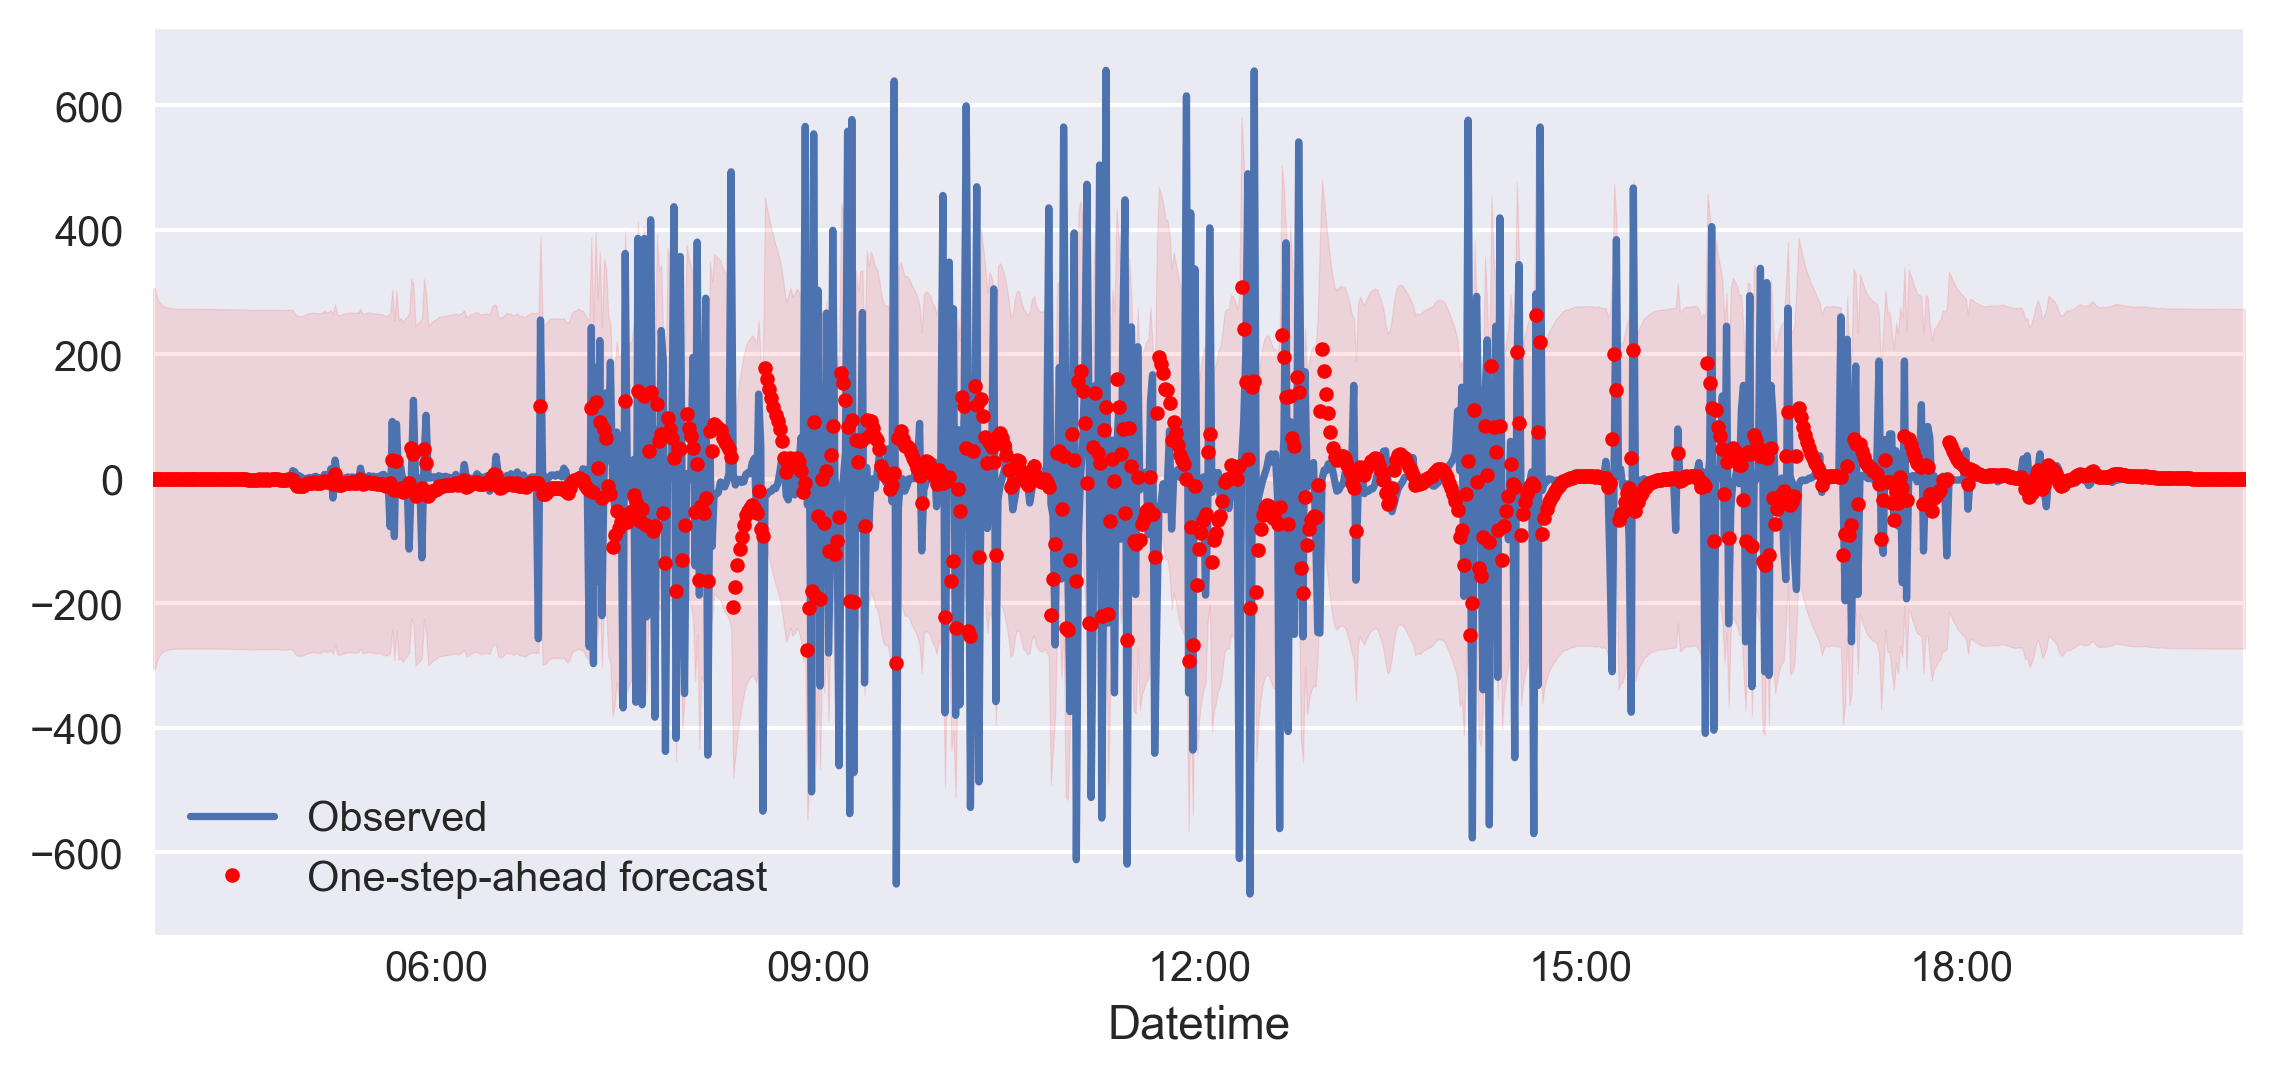

In [111]:
# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
varrennes_data_ghi_diff_0717.plot(ax=ax, style="-", label="Observed")

# Plot predictions
prediction_bayes_ghi_diff_sarimax.predicted_mean.plot(ax=ax, style="r.", label="One-step-ahead forecast")
ax.fill_between(prediction_bayes_ghi_diff_sarimax_ci.index, 
                prediction_bayes_ghi_diff_sarimax_ci['lower G1 (W/m2)'], 
                prediction_bayes_ghi_diff_sarimax_ci['upper G1 (W/m2)'],
                color="r", alpha=0.1)
ax.legend(loc="lower left")
plt.show()

#### Use extracted code to perform the same work

In [137]:
from bayesian_sarimax import BayesianSarimaxManager

In [138]:
ghi_diff_bayasian_sarimax = BayesianSarimaxManager(varrennes_data_ghi_diff_0717)

In [139]:
ghi_diff_bayasian_sarimax.perform()

/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma2, ma.l1, ar.l1]


/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tools/numdiff.py:246: RuntimeWarning: invalid value encountered in multiply
  increments = np.identity(n) * 1j * epsilon


Sampling 2 chains for 600 tune and 3_000 draw iterations (1_200 + 6_000 draws total) took 885 seconds.
The acceptance probability does not match the target. It is 0.9575720547117229, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842128640047365, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning: A valid var_name should be provided, found {'ma.L1', 'ar.L1'} expected from {'ma.l1', 'sigma2', 'ar.l1'}
  warnings.warn(


<Figure size 576x396 with 0 Axes>

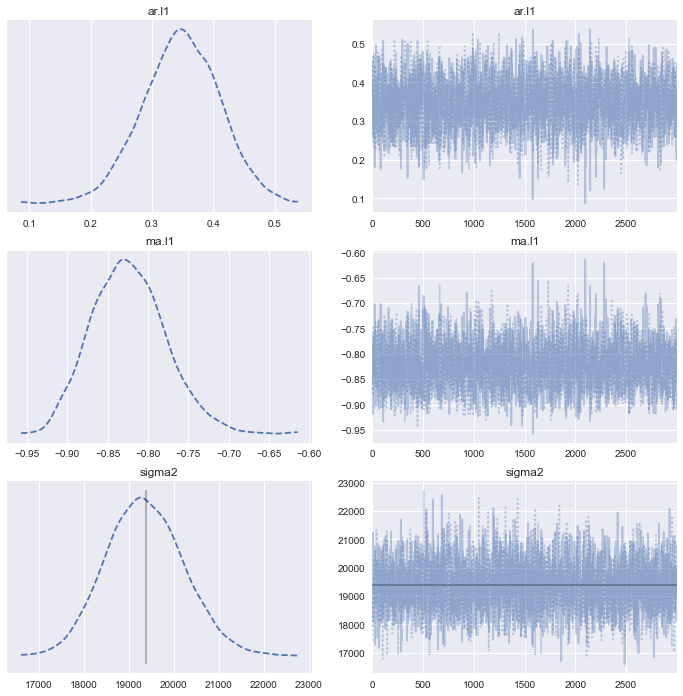

In [140]:
ghi_diff_bayasian_sarimax.plot_pymc3_trace()

In [141]:
ghi_diff_bayasian_sarimax.pymc3_trace_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar.l1,0.347,0.063,0.229,0.465,0.001,0.001,2246.0,2336.0,1.0
ma.l1,-0.824,0.046,-0.911,-0.742,0.001,0.001,2242.0,2304.0,1.0
sigma2,19361.753,867.747,17796.556,21020.375,15.810,11.204,3027.0,2980.0,1.0


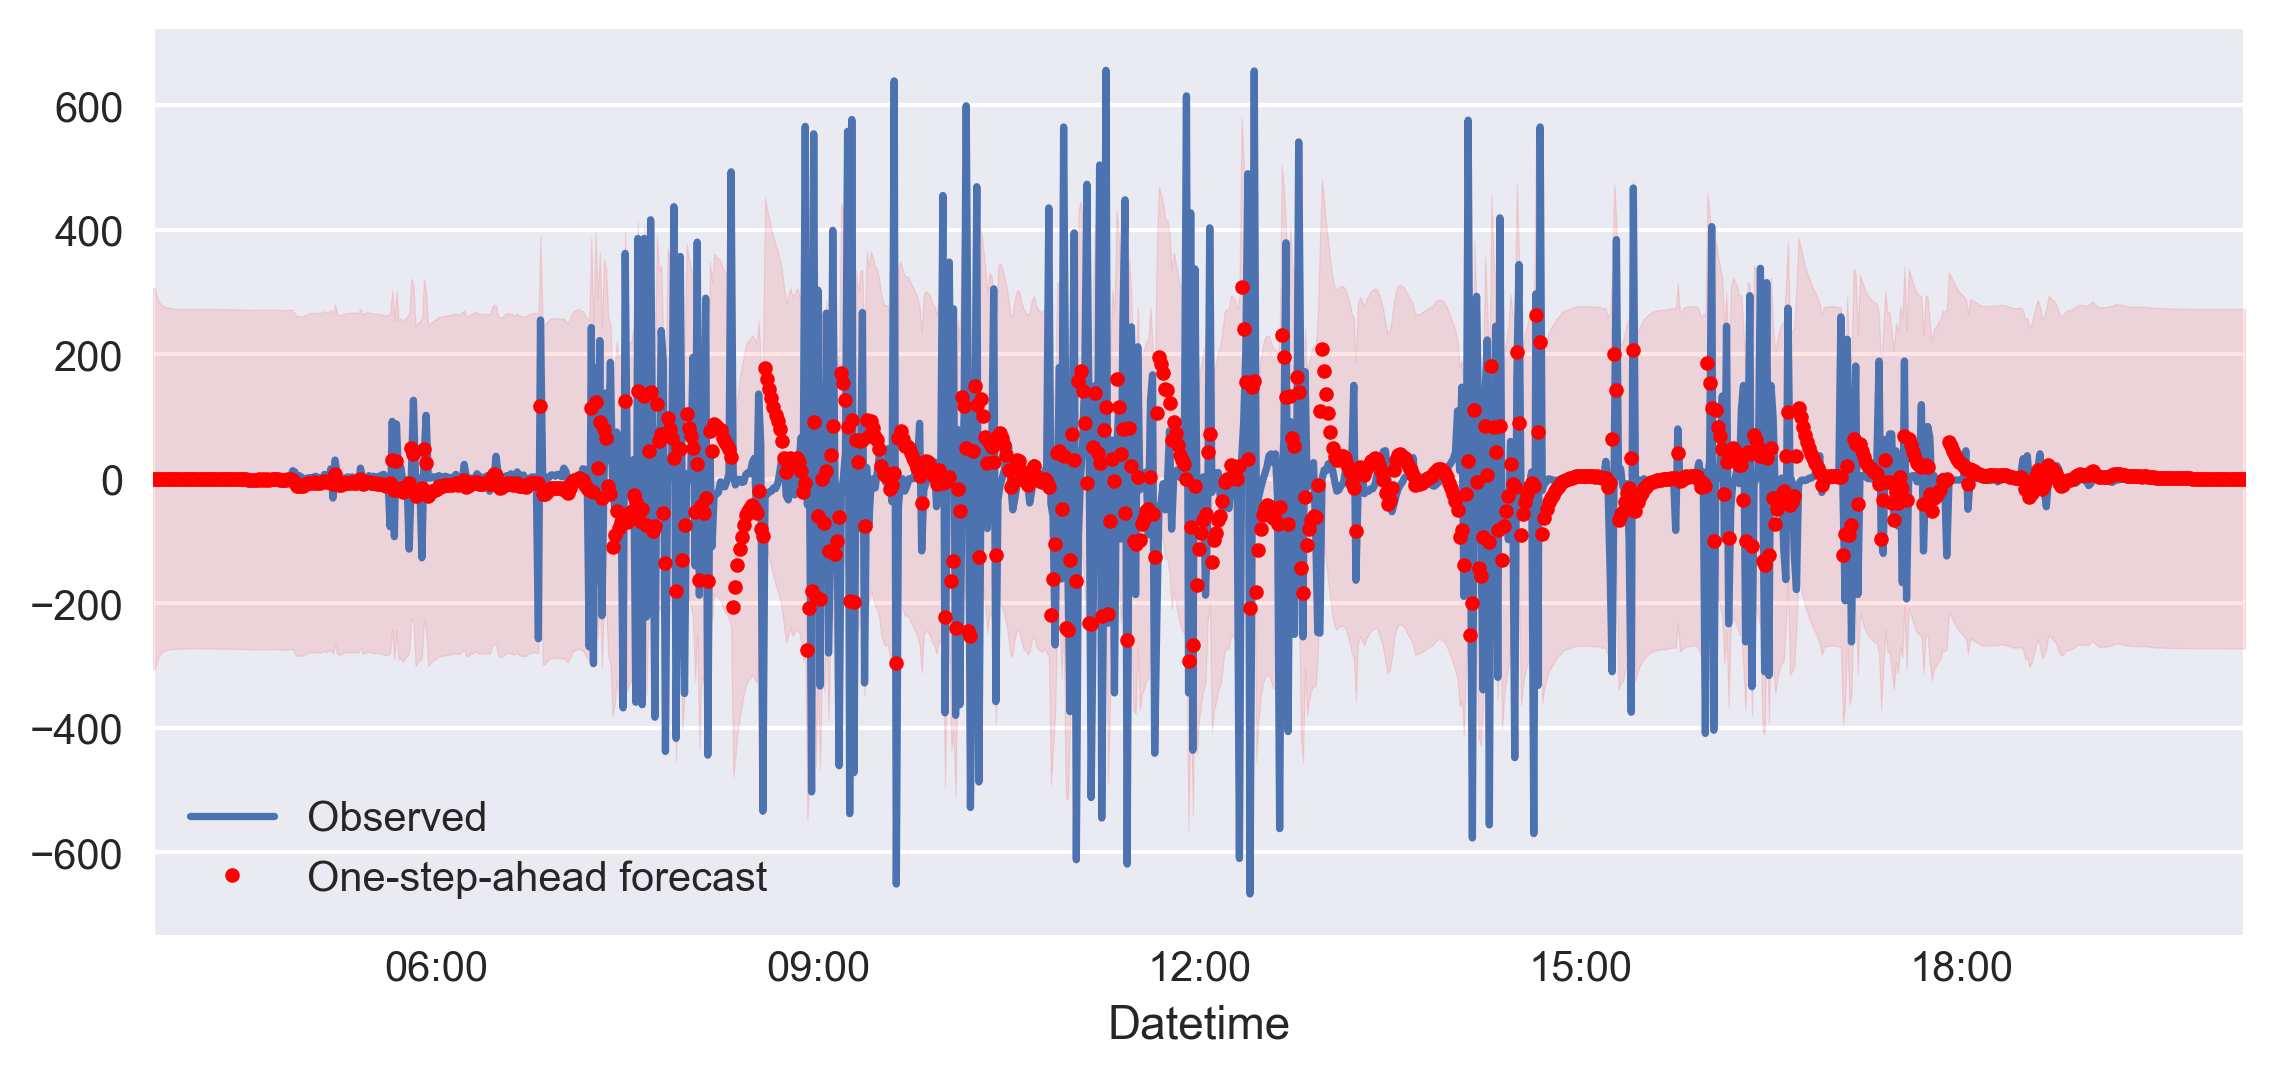

In [142]:
ghi_diff_bayasian_sarimax.plot_pymc3_application()

#### Creating the consolidating code is successful. 

#### Now, first, try to get back the original data from the first difference. 

In [170]:
varrennes_data_ghi_from_diff_0717 = varrennes_data_ghi_diff_0717.cumsum().dropna() + varrennes_data_ghi_0717[0]

<AxesSubplot:xlabel='Datetime'>

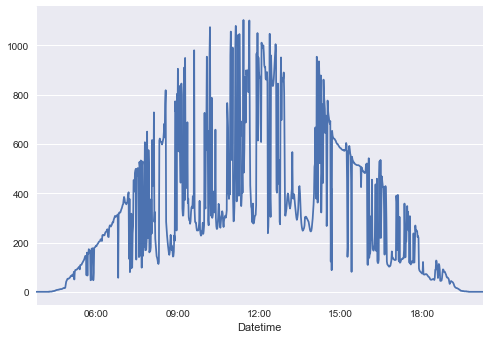

In [171]:
varrennes_data_ghi_from_diff_0717.plot()

In [150]:
varrennes_data_ghi_0717.index[0]

Timestamp('2014-07-17 03:46:00-0400', tz='Canada/Eastern')

In [159]:
varrennes_data_ghi_first_row_0717 = varrennes_data_ghi_0717[varrennes_data_ghi_0717.index == varrennes_data_ghi_0717.index[0]]

In [160]:
varrennes_data_ghi_first_row_0717

Datetime
2014-07-17 03:46:00-04:00    0
Name: G1 (W/m2), dtype: int64

In [172]:
varrennes_data_ghi_from_diff_0717 = pd.concat([varrennes_data_ghi_first_row_0717, varrennes_data_ghi_from_diff_0717])

In [173]:
varrennes_data_ghi_from_diff_0717

Datetime
2014-07-17 03:46:00-04:00    0.0
2014-07-17 03:47:00-04:00    0.0
2014-07-17 03:48:00-04:00    0.0
2014-07-17 03:49:00-04:00    0.0
2014-07-17 03:50:00-04:00    0.0
                            ... 
2014-07-17 20:10:00-04:00    0.0
2014-07-17 20:11:00-04:00    0.0
2014-07-17 20:12:00-04:00    0.0
2014-07-17 20:13:00-04:00    0.0
2014-07-17 20:14:00-04:00    0.0
Name: G1 (W/m2), Length: 989, dtype: float64

<AxesSubplot:xlabel='Datetime'>

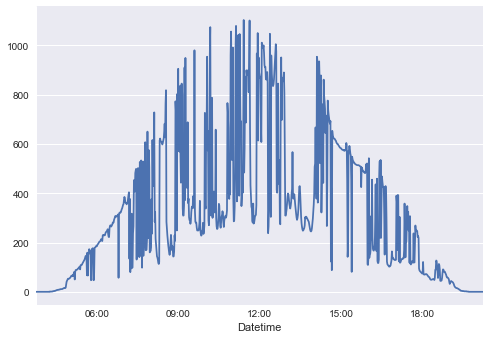

In [174]:
varrennes_data_ghi_from_diff_0717.plot()

In [177]:
varrennes_data_ghi_0717.compare(varrennes_data_ghi_from_diff_0717)

,self,other
Datetime,,


#### Success.

#### Now, create a function to reproduce the original data from first difference.

In [179]:
from first_difference_to_original import produce_data_from_first_difference

In [180]:
varrennes_data_ghi_from_diff_0717_2 = produce_data_from_first_difference(
    varrennes_data_ghi_diff_0717, varrennes_data_ghi_0717)

In [181]:
varrennes_data_ghi_0717.compare(varrennes_data_ghi_from_diff_0717_2)

,self,other
Datetime,,


<AxesSubplot:xlabel='Datetime'>

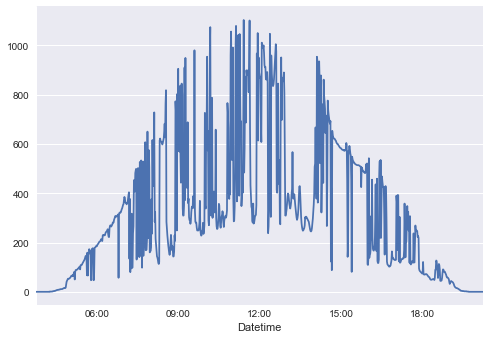

In [182]:
varrennes_data_ghi_from_diff_0717_2.plot()

#### Now, get data from the first difference data from Time Series Analysis.

In [183]:
predicted_ghi_diff = prediction_bayes_ghi_diff_sarimax.predicted_mean

In [189]:
predicted_ghi_diff

2014-07-17 03:46:00-04:00    0.000000
2014-07-17 03:47:00-04:00    0.000000
2014-07-17 03:48:00-04:00    0.000000
2014-07-17 03:49:00-04:00    0.000000
2014-07-17 03:50:00-04:00    0.000000
                               ...   
2014-07-17 20:10:00-04:00    0.006088
2014-07-17 20:11:00-04:00    0.005016
2014-07-17 20:12:00-04:00    0.004134
2014-07-17 20:13:00-04:00    0.003406
2014-07-17 20:14:00-04:00    0.002807
Freq: T, Name: predicted_mean, Length: 989, dtype: float64

<AxesSubplot:>

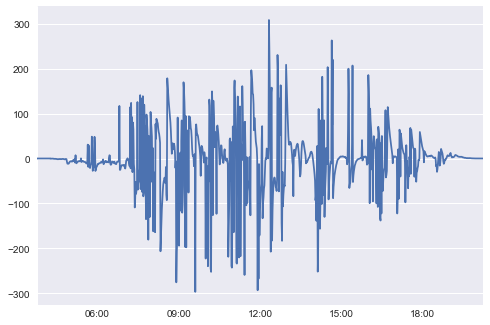

In [188]:
predicted_ghi_diff.plot()

<AxesSubplot:xlabel='Datetime'>

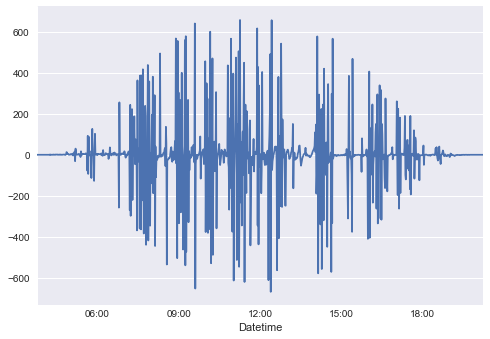

In [195]:
varrennes_data_ghi_diff_0717.plot()

In [191]:
varrennes_data_ghi_0717

Datetime
2014-07-17 03:46:00-04:00    0
2014-07-17 03:47:00-04:00    0
2014-07-17 03:48:00-04:00    0
2014-07-17 03:49:00-04:00    0
2014-07-17 03:50:00-04:00    0
                            ..
2014-07-17 20:10:00-04:00    0
2014-07-17 20:11:00-04:00    0
2014-07-17 20:12:00-04:00    0
2014-07-17 20:13:00-04:00    0
2014-07-17 20:14:00-04:00    0
Name: G1 (W/m2), Length: 989, dtype: int64

In [192]:
varrennes_data_ghi_0717.shift().dropna()

Datetime
2014-07-17 03:47:00-04:00    0.0
2014-07-17 03:48:00-04:00    0.0
2014-07-17 03:49:00-04:00    0.0
2014-07-17 03:50:00-04:00    0.0
2014-07-17 03:51:00-04:00    0.0
                            ... 
2014-07-17 20:10:00-04:00    0.0
2014-07-17 20:11:00-04:00    0.0
2014-07-17 20:12:00-04:00    0.0
2014-07-17 20:13:00-04:00    0.0
2014-07-17 20:14:00-04:00    0.0
Name: G1 (W/m2), Length: 988, dtype: float64

In [193]:
predicted_ghi = produce_data_from_first_difference(predicted_ghi_diff, varrennes_data_ghi_0717)

<AxesSubplot:>

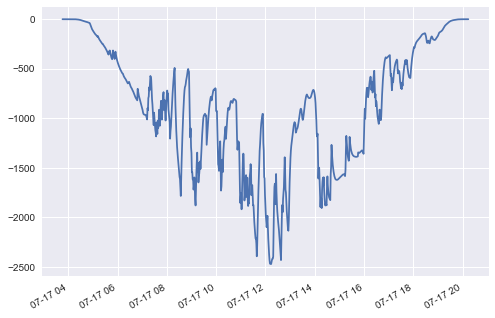

In [196]:
predicted_ghi.plot()

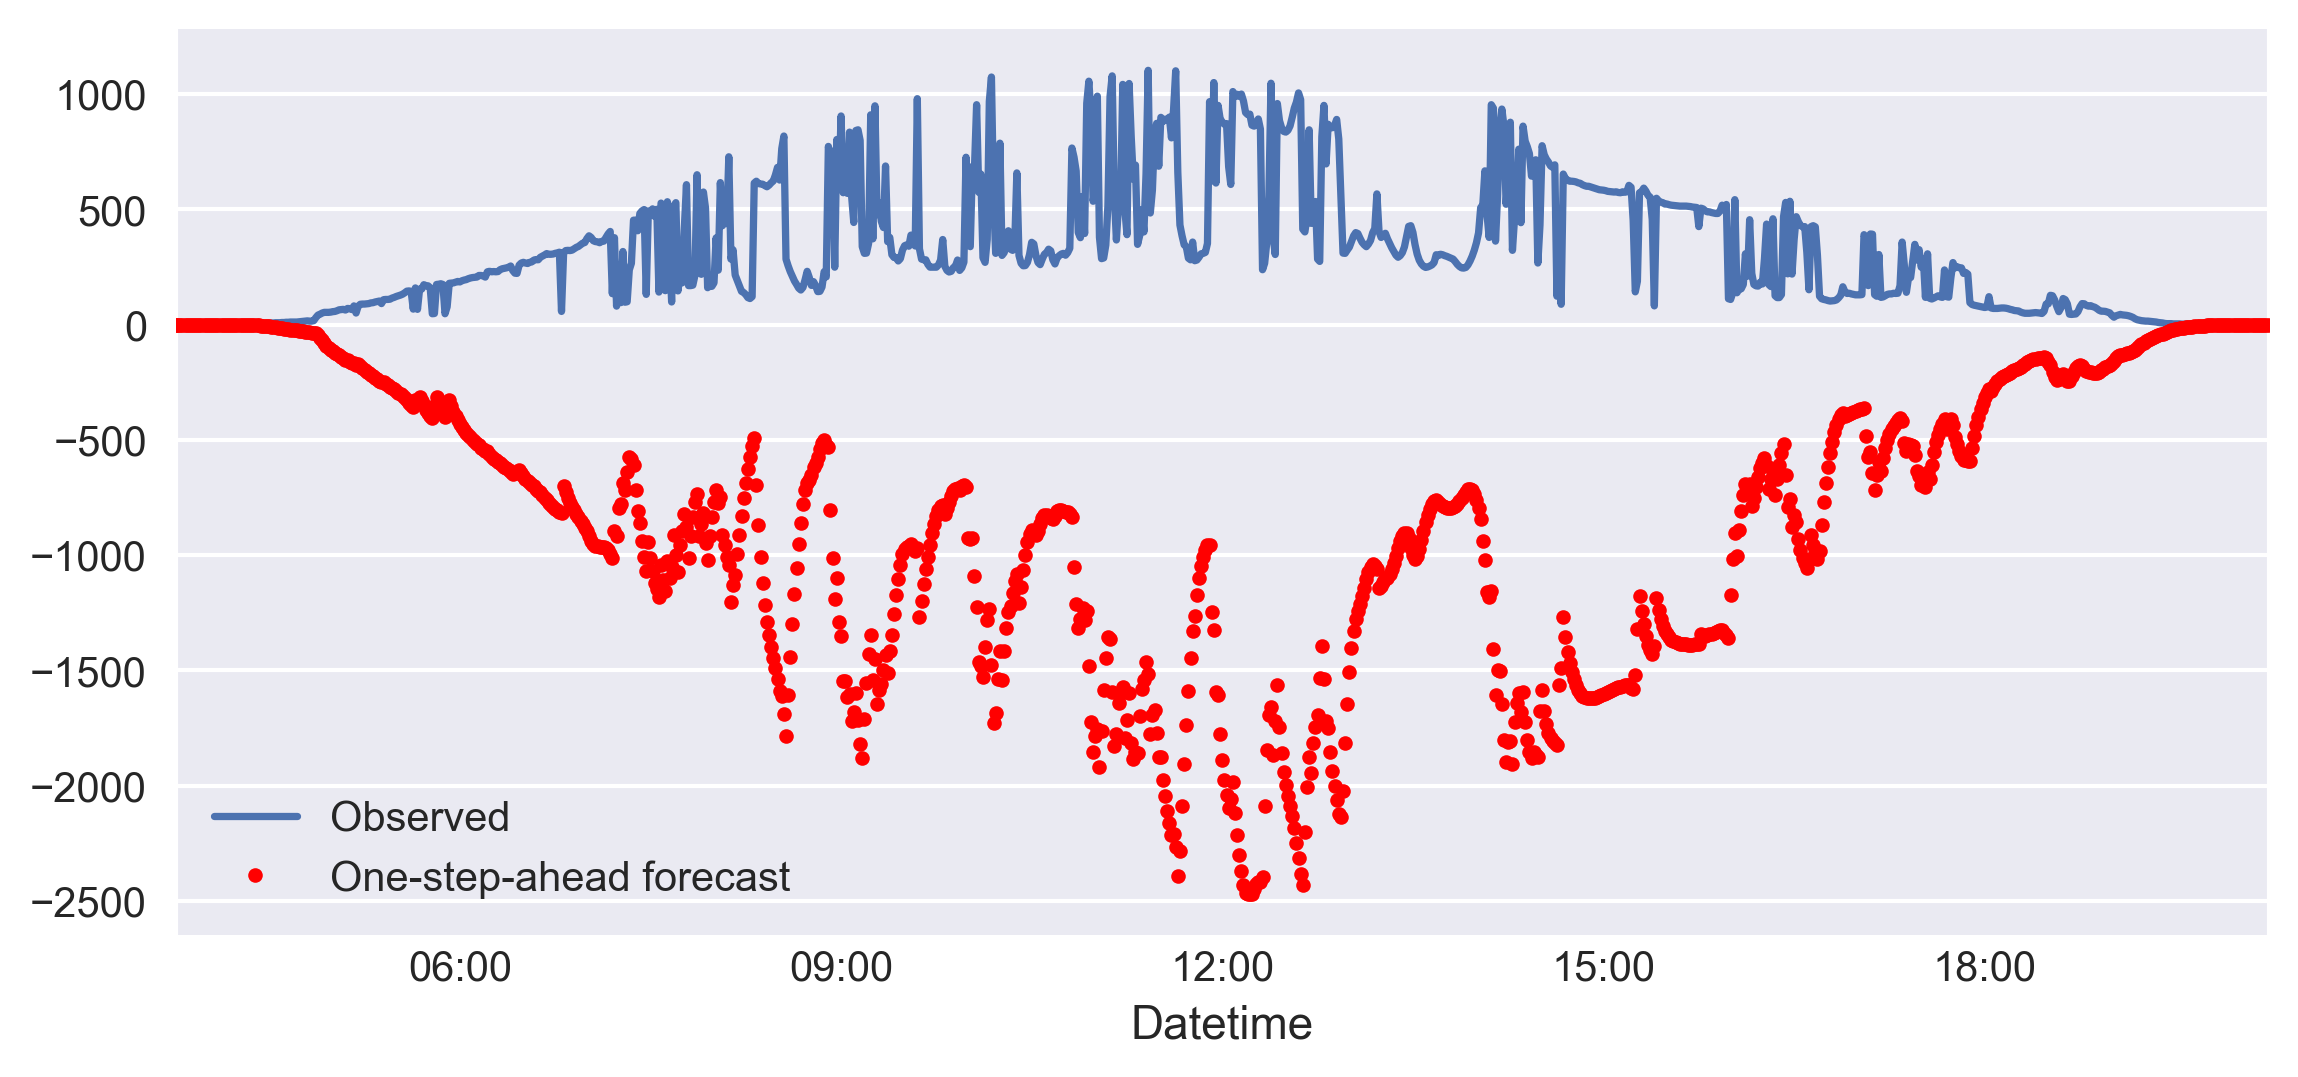

In [194]:
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

varrennes_data_ghi_0717.plot(ax=ax, style="-", label="Observed")

# Plot predictions
predicted_ghi.plot(
            ax=ax, style="r.", label="One-step-ahead forecast")

ax.legend(loc="lower left")
plt.show()

#### This is a huge problem. 

#### Try to apply Time Series Analysis on original data - clearsky data

#### First difference data from the first one.

<AxesSubplot:xlabel='Datetime'>

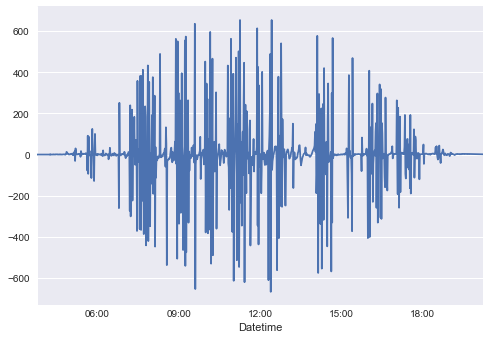

In [197]:
varrennes_data_data_residual_diff_0717.plot()

In [198]:
residual_diff_bayasian_sarimax = BayesianSarimaxManager(varrennes_data_data_residual_diff_0717)

In [199]:
residual_diff_bayasian_sarimax.perform()

/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma2, ma.l1, ar.l1]


/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tools/numdiff.py:246: RuntimeWarning: invalid value encountered in multiply
  increments = np.identity(n) * 1j * epsilon


Sampling 2 chains for 600 tune and 3_000 draw iterations (1_200 + 6_000 draws total) took 673 seconds.
The acceptance probability does not match the target. It is 0.8831182036738385, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9022125323604002, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning: A valid var_name should be provided, found {'ma.L1', 'ar.L1'} expected from {'ma.l1', 'sigma2', 'ar.l1'}
  warnings.warn(


<Figure size 576x396 with 0 Axes>

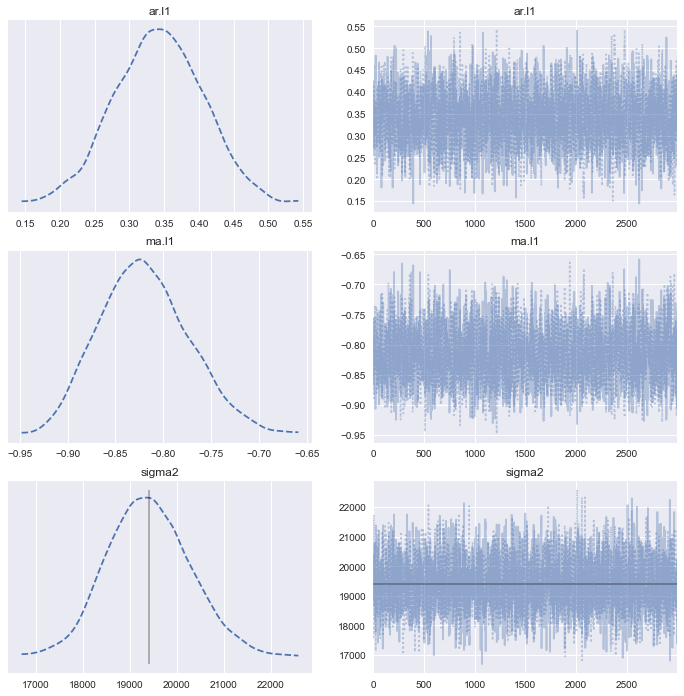

In [200]:
residual_diff_bayasian_sarimax.plot_pymc3_trace()

In [201]:
residual_diff_bayasian_sarimax.pymc3_trace_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar.l1,0.343,0.063,0.227,0.466,0.001,0.001,2373.0,2316.0,1.0
ma.l1,-0.819,0.046,-0.903,-0.733,0.001,0.001,2337.0,2293.0,1.0
sigma2,19403.709,875.468,17751.389,21048.693,14.348,10.165,3735.0,3382.0,1.0


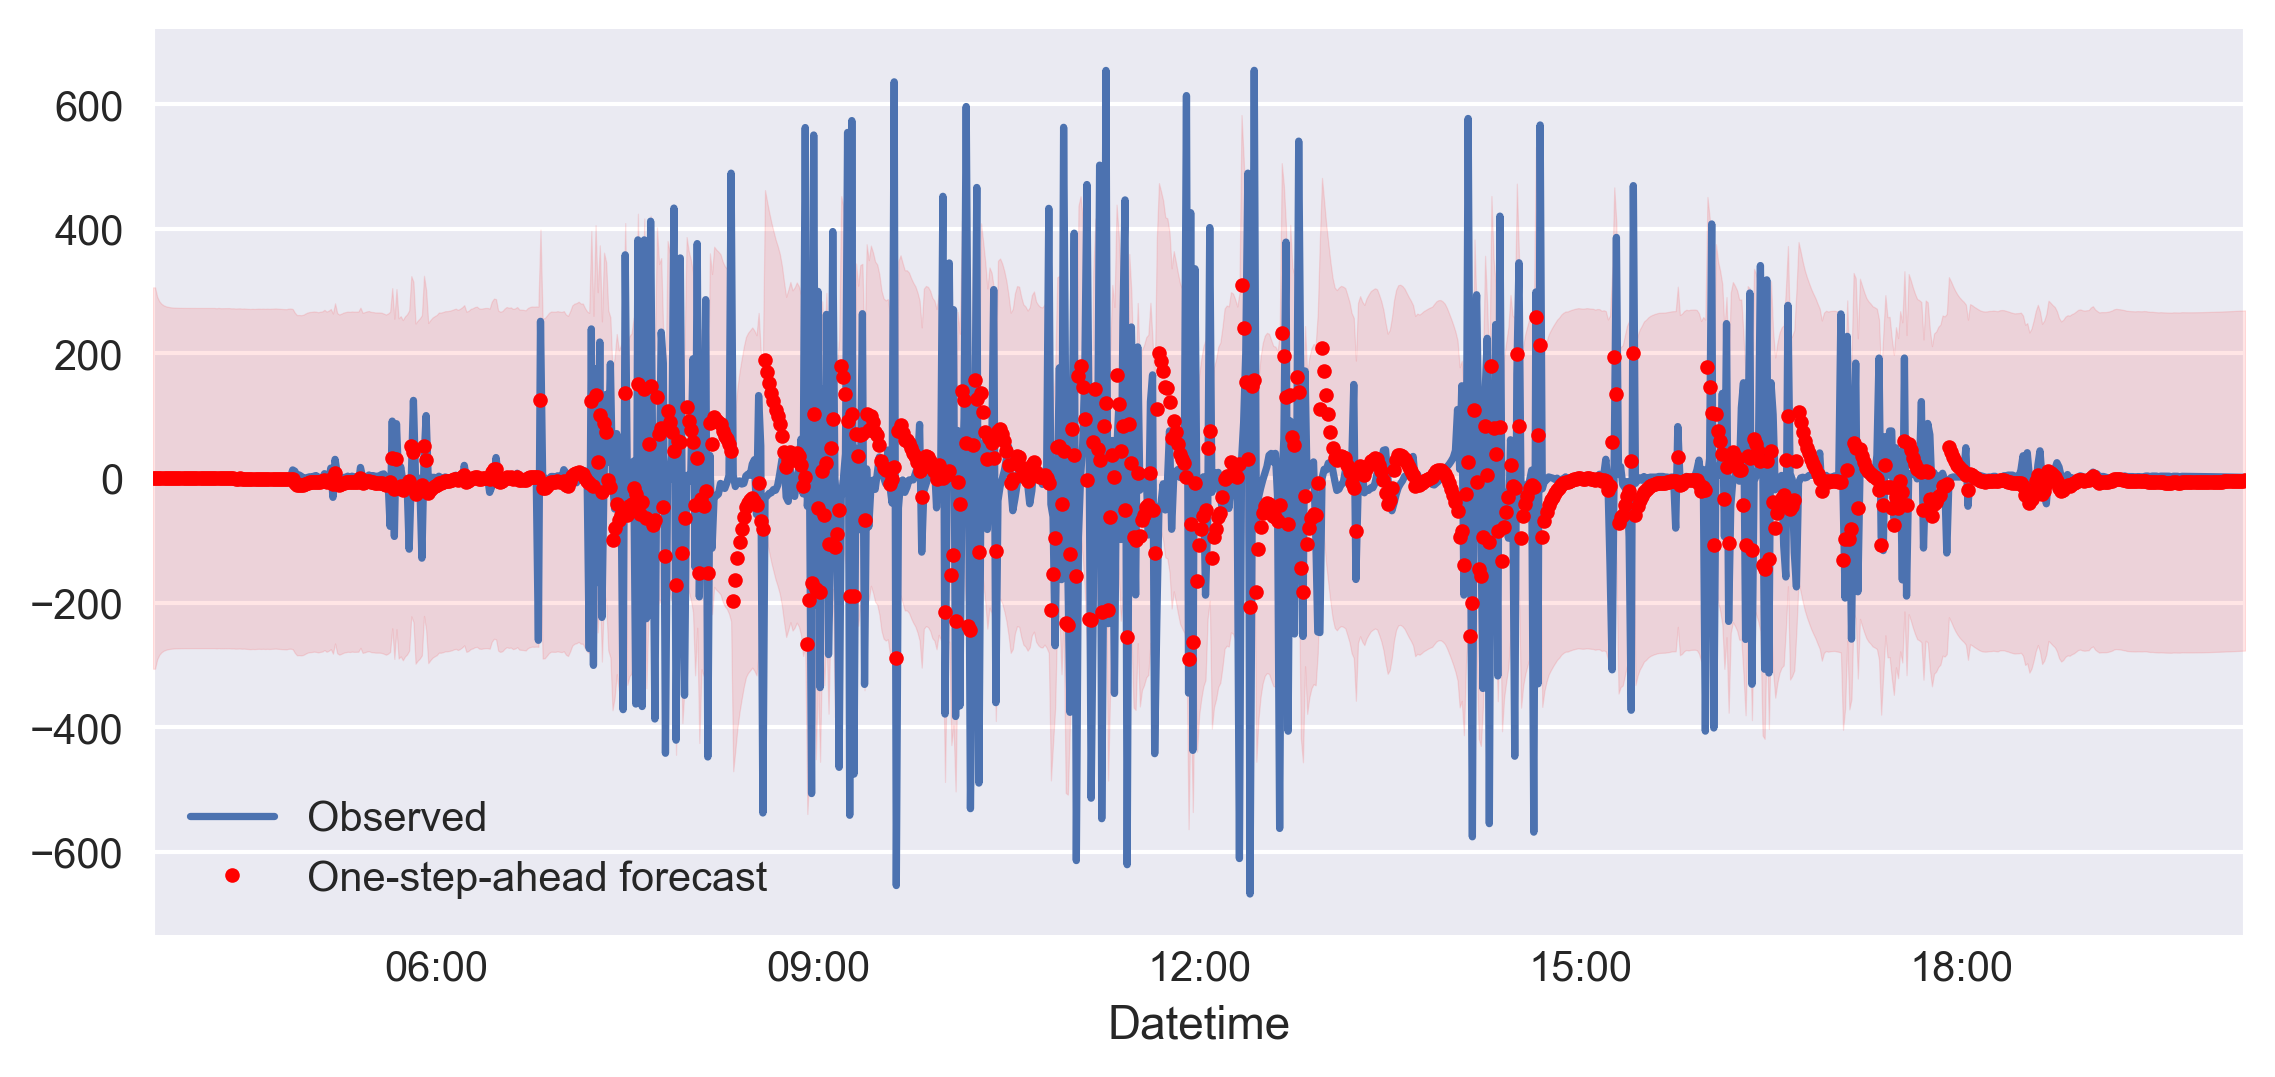

In [202]:
residual_diff_bayasian_sarimax.plot_pymc3_application()

In [203]:
predicted_residual_diff = residual_diff_bayasian_sarimax.bayes_sarimax_prediction.predicted_mean

In [204]:
predicted_residual_diff

2014-07-17 03:46:00-04:00    0.000000
2014-07-17 03:47:00-04:00    0.000000
2014-07-17 03:48:00-04:00    0.000000
2014-07-17 03:49:00-04:00    0.000000
2014-07-17 03:50:00-04:00    0.000000
                               ...   
2014-07-17 20:10:00-04:00   -4.599625
2014-07-17 20:11:00-04:00   -4.433708
2014-07-17 20:12:00-04:00   -4.264202
2014-07-17 20:13:00-04:00   -4.091343
2014-07-17 20:14:00-04:00   -3.915409
Freq: T, Name: predicted_mean, Length: 989, dtype: float64

<AxesSubplot:>

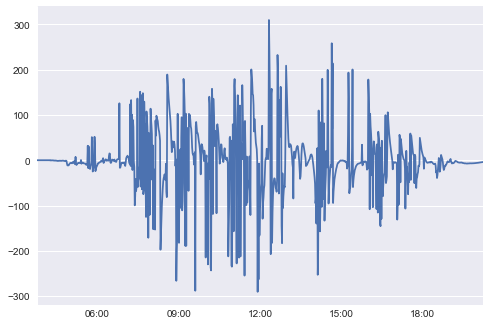

In [205]:
predicted_residual_diff.plot()

In [206]:
predicted_residual = produce_data_from_first_difference(predicted_residual_diff, varrennes_data_data_residual_0717)

In [207]:
predicted_residual

2014-07-17 03:46:00-04:00     0.000000
2014-07-17 03:46:00-04:00     0.000000
2014-07-17 03:47:00-04:00     0.000000
2014-07-17 03:48:00-04:00     0.000000
2014-07-17 03:49:00-04:00     0.000000
                               ...    
2014-07-17 20:10:00-04:00    61.273259
2014-07-17 20:11:00-04:00    56.839551
2014-07-17 20:12:00-04:00    52.575349
2014-07-17 20:13:00-04:00    48.484006
2014-07-17 20:14:00-04:00    44.568597
Length: 990, dtype: float64

<AxesSubplot:>

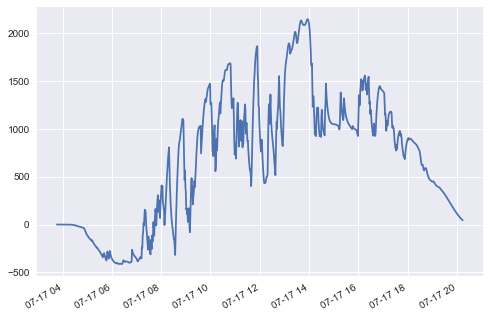

In [208]:
predicted_residual.plot()

<AxesSubplot:xlabel='Datetime'>

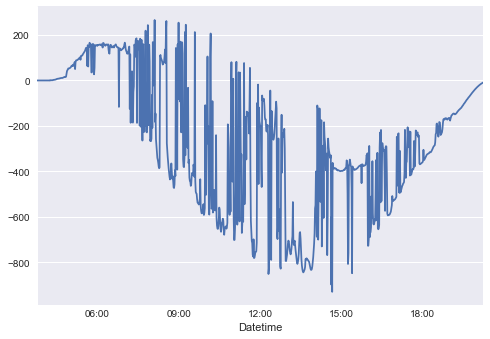

In [209]:
varrennes_data_data_residual_0717.plot()

<AxesSubplot:>

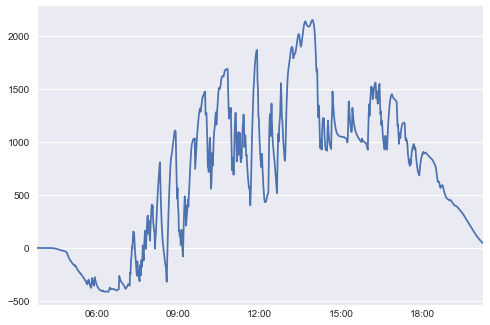

In [210]:
predicted_residual_diff.cumsum().dropna().plot()

<AxesSubplot:>

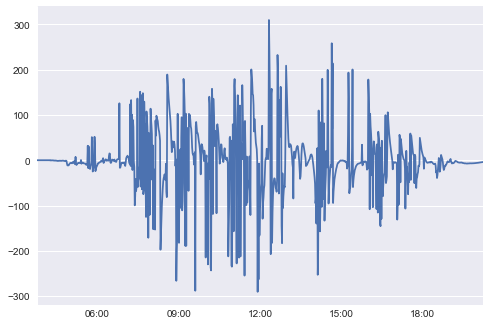

In [211]:
predicted_residual_diff.plot()

<AxesSubplot:>

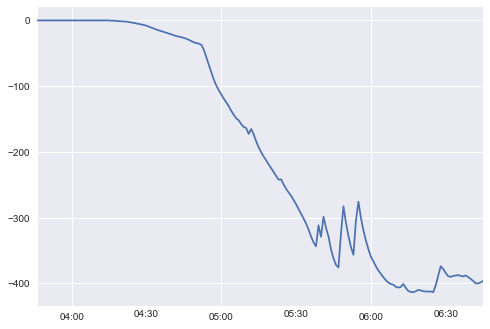

In [213]:
predicted_residual_diff[:180].cumsum().dropna().plot()

<AxesSubplot:>

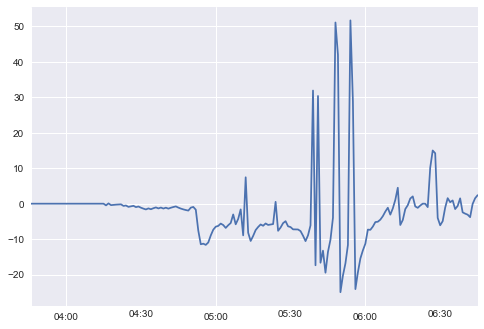

In [214]:
predicted_residual_diff[:180].plot()

In [215]:
predicted_ghi_from_residual = predicted_residual + varrennes_clearsky_ghi_scaled_0717

<AxesSubplot:>

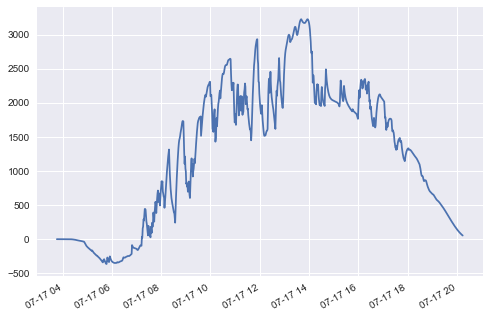

In [216]:
predicted_ghi_from_residual.plot()

<AxesSubplot:>

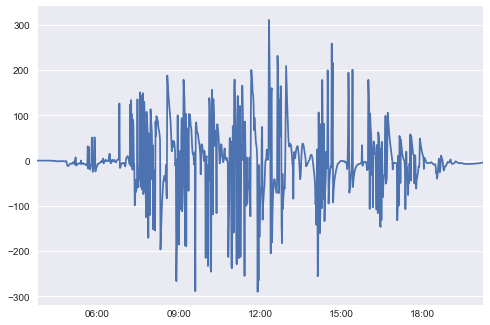

In [219]:
residual_diff_bayasian_sarimax.sarimax_result.get_prediction().predicted_mean.plot()

In [222]:
residual_diff_bayasian_sarimax.sarimax_result.get_prediction().predicted_mean.compare(predicted_residual_diff)

,self,other
2014-07-17 04:16:00-04:00,-0.477537,-0.475998
2014-07-17 04:17:00-04:00,0.083407,0.086157
2014-07-17 04:18:00-04:00,-0.408699,-0.405437
2014-07-17 04:19:00-04:00,-0.337317,-0.332053
2014-07-17 04:20:00-04:00,-0.278402,-0.271951
...,...,...
2014-07-17 20:10:00-04:00,-4.811245,-4.599625
2014-07-17 20:11:00-04:00,-4.639700,-4.433708
2014-07-17 20:12:00-04:00,-4.464387,-4.264202
2014-07-17 20:13:00-04:00,-4.285550,-4.091343


In [224]:
predicted_residual_diff.shape

(989,)

#### It seems that the SARIMAX model is incorrect. Maybe, GARCH can be used since the variance of first difference changes over time.